Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/SRGAN


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/SRGAN


Install relevant packages

In [ ]:
!pip install -r requirements.txt
!pip install git+https://www.github.com/keras-team/keras-contrib.git

Load Images and Store them in a Numpy file (One time use)

In [ ]:
#Image Dataset: http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html , filename:img_align_celeba.zip
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "img_align_celeba.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip:  
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!') 

In [ ]:
low_res_images=[]
high_res_images=[]
count=0
for img in os.listdir('img_align_celeba'):
  if '.zip' not in img: 
    count+=1
    img1 = imread('images/'+img, mode='RGB')
    img1 = img1.astype(np.float32)

    img1_high_res=imresize(img1,(256,256,3))
    img1_low_res=imresize(img1,(64,64,3))

    if np.random.random()<0.5:
      img1_high_res=np.fliplr(img1_high_res)
      img1_low_res=np.fliplr(img1_low_res)

    low_res_images.append(img1_low_res)
    high_res_images.append(img1_high_res)
    if count%100==0:
      print(count)

In [ ]:
low_res_images=np.array(low_res_images)
high_res_images=np.array(high_res_images)
np.save('low',low_res_images)
np.save('high',high_res_images)

Load Project Libraries

In [ ]:

import glob 
import os
import numpy as np
import tensorflow as tf
from keras import Input
from keras.applications  import VGG19
from keras.callbacks import TensorBoard
from keras.layers import BatchNormalization,LeakyReLU,PReLU,Dense, Add,Activation,Flatten
from keras.layers.convolutional import Conv2D,UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from keras_preprocessing.image import img_to_array,load_img
from PIL import Image
from scipy.misc import imsave,imread,imresize
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt


Using TensorFlow backend.


Load Image numpy files into numpy arrays

In [ ]:
main_high_res_images=np.load('high.npy')
len(main_high_res_images)

In [ ]:
main_low_res_images=np.load('low.npy')
len(main_low_res_images)

50000

Process Image data

In [ ]:

def sample_images(data_dir,batch_size,low_resolution_shape,high_resolution_shape):
  image_batch=np.random.randint(0,len(main_high_res_images))

  return np.array([main_high_res_images[image_batch]]),np.array([main_low_res_images[image_batch]])






In [ ]:
def save_images(low_resolution_image, original_image, generated_image, path):
    """
    Save low-resolution, high-resolution(original) and
    generated high-resolution images in a single image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(low_resolution_image)
    ax.axis("off")
    ax.set_title("Low-resolution")

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(original_image)
    ax.axis("off")
    ax.set_title("Original")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(generated_image)
    ax.axis("off")
    ax.set_title("Generated")

    plt.savefig(path)


Generator

In [ ]:
def build_generator():
  residual_block_count=16
  momentum=0.8
  input_shape=(64,64,3)
  input_layer=Input(shape=input_shape)

  net1=Conv2D(filters=64,kernel_size=9,strides=1,padding='same',activation='relu')(input_layer)



  def res_block(x):
    filters=[64,64]
    kernel_size=3
    strides=1
    padding='same'
    momentum=0.8
    activation='relu'
    res=Conv2D(filters=filters[0],kernel_size=kernel_size,strides=strides,padding='same',activation='relu')(x)
    res=Activation(activation=activation)(res)
    res=BatchNormalization(momentum=momentum)(res)
    res=Conv2D(filters=filters[1],kernel_size=kernel_size,strides=strides,padding='same',activation='relu')(res)
    res=BatchNormalization(momentum=momentum)(res)
    res=Add()([res,x])
    return res

  res=res_block(net1)
  for i in range(residual_block_count):
    res=res_block(res)

  net2=Conv2D(filters=64,kernel_size=3,strides=1,padding='same')(res)
  net2=BatchNormalization(momentum=0.8)(net2)
  net3=Add()([net2,net1])

  net4=UpSampling2D(size=2)(net3)
  net4=Conv2D(filters=256,kernel_size=3,padding='same',strides=1)(net4)
  net4=Activation('relu')(net4)

  net5=UpSampling2D(size=2)(net4)
  net5=Conv2D(filters=256,kernel_size=3,padding='same',strides=1)(net5)
  net5=Activation('relu')(net5)

  net6=Conv2D(filters=3,kernel_size=9,strides=1,padding='same')(net5)
  net6=Activation(activation='tanh')(net6)

  model=Model(inputs=[input_layer],outputs=[net6],name='generator')

  return model






Discriminator

In [ ]:
def build_discriminator():
  leakyrelu_alpha=  0.2
  momentum=0.8
  input_shape=(256,256,3)
  input_layer=Input(shape=input_shape)

  net1=Conv2D(filters=64,kernel_size=3,strides=1,
              padding='same')(input_layer)
  net1=LeakyReLU(alpha=leakyrelu_alpha)(net1)

  net2=Conv2D(filters=64,kernel_size=3,strides=2,padding='same')(net1)
  net2=LeakyReLU(alpha=leakyrelu_alpha)(net2)
  net2=BatchNormalization(momentum=momentum)(net2)

  net3=Conv2D(filters=128,kernel_size=3,strides=1,padding='same')(net2)
  net3=LeakyReLU(alpha=leakyrelu_alpha)(net3)
  net3=BatchNormalization(momentum=momentum)(net3)

  net4=Conv2D(filters=128,kernel_size=3,strides=2,padding='same')(net3)
  net4=LeakyReLU(alpha=leakyrelu_alpha)(net4)
  net4=BatchNormalization(momentum=momentum)(net4)
    
  net5=Conv2D(filters=256,kernel_size=3,strides=1,padding='same')(net4)
  net5=LeakyReLU(alpha=leakyrelu_alpha)(net5)
  net5=BatchNormalization(momentum=momentum)(net5)
  
  net6=Conv2D(filters=256,kernel_size=3,strides=2,padding='same')(net5)
  net6=LeakyReLU(alpha=leakyrelu_alpha)(net6)
  net6=BatchNormalization(momentum=momentum)(net6)
    
  net7=Conv2D(filters=512,kernel_size=3,strides=1,padding='same')(net6)
  net7=LeakyReLU(alpha=leakyrelu_alpha)(net7)
  net7=BatchNormalization(momentum=momentum)(net7)
  
  net8=Conv2D(filters=512,kernel_size=3,strides=2,padding='same')(net7)
  net8=LeakyReLU(alpha=leakyrelu_alpha)(net8)
  net8=BatchNormalization(momentum=momentum)(net8)

  net9=Dense(units=1024)(net8)
  net9=LeakyReLU(alpha=0.2)(net9)
  output=Dense(units=1,activation='sigmoid')(net9)

  model=Model(inputs=[input_layer],outputs=[output],name='discriminator')
  return model


VGG19

In [ ]:
def build_vgg():
  input_shape=(256,256,3)
  vgg=VGG19(weights='imagenet',include_top=False,input_shape=input_shape)
  # print(vgg.summary())
  vgg.outputs=[vgg.layers[9].output]
  

  input_layer=Input(shape=input_shape)
  features=vgg(input_layer)
  model=Model(inputs=[input_layer],outputs=[features])
  model.compile(loss='mse',optimizer=common_opt,metrics=['accuracy'])

  return model


Adversarial Model

In [ ]:
def build_adversarial(generator,discriminator,vgg):
  input_low_res=Input(shape=(64,64,3))
  fake_hr_images=generator(input_low_res)
  fake_features=vgg(fake_hr_images)
  discriminator.trainable=False
  output=discriminator(fake_hr_images)
  model=Model(inputs=[input_low_res],outputs=[output,fake_features])
  return model

Training our GAN

In [ ]:
epochs=20000
batch_size=1
low_res_shape=(64,64,3)
high_res_shape=(256,256,3)
common_opt=Adam(0.0002,0.5)
data='/'


discriminator=build_discriminator()
discriminator.compile(loss='mse',optimizer=common_opt,metrics=['accuracy'])
if 'discriminator.h5' in os.listdir():
  discriminator.load_weights('discriminator.h5')
print('disc ready')
generator=build_generator()
input_low_res=Input(shape=low_res_shape)
input_high_res=Input(shape=high_res_shape)

gen_high_res_images=generator(input_low_res)
print('gen ready')

vgg=build_vgg()
vgg.trainable=False
features=vgg(gen_high_res_images)
print('vgg ready')

discriminator.trainable=False

probs=discriminator(gen_high_res_images)

adversarial_model=Model([input_low_res,input_high_res],[probs,features])
adversarial_model.compile(loss=['binary_crossentropy','mse'],loss_weights=[1e-3,1],optimizer=common_opt)
if 'generator.h5' in os.listdir():
  generator.load_weights('generator.h5')
print('adv model ready')

for epoch in range(0,epochs):
  if epoch%10==0:
    if 'discriminator.h5' in os.listdir():
      os.remove('discriminator.h5')
      os.remove('generator.h5')
  print('Epoch:{}'.format(epoch))
  high_res_images,low_res_images=sample_images(data_dir=data,batch_size=batch_size,low_resolution_shape=low_res_shape,high_resolution_shape=high_res_shape)
  print('images ready')

  high_res_images=high_res_images/127.5 - 1
  low_res_images=low_res_images/127.5 - 1

  gen_high_res_images=generator.predict(low_res_images)
  real_labels=np.ones((batch_size,16,16,1))
  fake_labels=np.zeros((batch_size,16,16,1))

  d_loss_real=discriminator.train_on_batch(high_res_images,real_labels)
  d_loss_fake=discriminator.train_on_batch(gen_high_res_images,fake_labels)
  print('disc trained')

  d_loss=0.5*np.add(d_loss_real,d_loss_fake)

  high_res_images,low_res_images=sample_images(data_dir=data,batch_size=batch_size,low_resolution_shape=low_res_shape,high_resolution_shape=high_res_shape)

  high_res_images=high_res_images/127.5 - 1
  low_res_images=low_res_images/127.5 - 1

  image_features=vgg.predict(high_res_images)
  print('vgg predicted')
  g_loss=adversarial_model.train_on_batch([low_res_images,high_res_images],[real_labels,image_features])
  print('adv model trained')
  print('d_loss_real:',d_loss_real)
  print('d_loss_fake:',d_loss_fake)
  print('d_loss:',d_loss)
  print('g_loss:',g_loss)

  if epoch%10==0:
    generator.save_weights('generator.h5')
    discriminator.save_weights('discriminator.h5')
    print('generator and discriminator weights for epoch{} has been saved'.format(epoch))
  
  if epoch%20==0:
    high_res_images,low_res_images=sample_images(data_dir=data,batch_size=batch_size,low_resolution_shape=low_res_shape,high_resolution_shape=high_res_shape)

    high_res_images=high_res_images/127.5 - 1
    low_res_images=low_res_images/127.5 - 1

    gen_images=generator.predict_on_batch(low_res_images)

    for index, img in enumerate(gen_images):
                        save_images(low_res_images[index], high_res_images[index], img,
                                    path="results/img_{}_{}".format(epoch, index))
                        print("results/img_{}_{}".format(epoch, index))



Predictor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


results/img_1_0


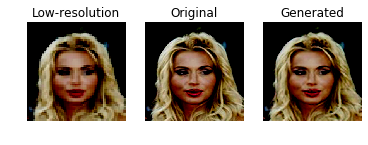

In [ ]:
generator=build_generator()
generator.load_weights('generator.h5')
data='/'
high_res_images,low_res_images=sample_images(data_dir=data,batch_size=1,low_resolution_shape=(64,64,3),high_resolution_shape=(256,256,3))

high_res_images=high_res_images/127.5 - 1
low_res_images=low_res_images/127.5 - 1

gen_images=generator.predict_on_batch(low_res_images)

for index, img in enumerate(gen_images):
  save_images(low_res_images[index], high_res_images[index], img,
              path="results/img_{}_{}".format(1, index))
  print("results/img_{}_{}".format(1, index))


Enhance Video Resolution Application

Extract frames from video files

In [ ]:
import cv2
import math
videoFile = 'video filename'
X=[]
cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
frameRate = cap.get(1) #frame rate
#print(cap.isOpened())
while(cap.isOpened()):
  #print(1)
  frameId = cap.get(1) #current frame number
  ret, frame = cap.read()
  if (ret != True):
      break
  frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  frame = cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE) 


  X_temp = frame
  img1 = X_temp.astype(np.float32)
  X.append(imresize(X_temp,(64,64,3)))
cap.release()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Generate Upscaled video frames and store them as individual files

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
generator=build_generator()
# generator.load_weights('generator.h5')
data='/'
count=0
final=[]
for i in range(0,len(X),2):
  # print(i)
  high_res_images,low_res_images=sample_images(X[i],batch_size=1,low_resolution_shape=(64,64,3),high_resolution_shape=(256,256,3))

  low_res_images=low_res_images/127.5 - 1
  gen_images=generator.predict_on_batch(np.array([low_res_images]))
  imsave('video_data/img_{}.png'.format(count),X[i])
  print(count)
  count+=1


Combine all the above generated frame files into a single video

In [ ]:
from os.path import isfile, join

def convert_frames_to_video(pathIn,pathOut,fps):
    frame_array = []
    files=[]
    for i in range(len(os.listdir(pathIn))):
      files.append(pathIn+'/'+'img_{}.png'.format(i))
    # print(files)


    for i in range(len(files)-1):
        filename=files[i]
        #reading each files
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        print(filename)
        #inserting the frames into an image array
        frame_array.append(img)

    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    out.release()

def main():
    pathOut = 'video.avi'
    fps = 25.0
    convert_frames_to_video('video_data', pathOut, fps)

if __name__=="__main__":
    main()